In [1]:
from calibrator import *
from analysis import *
from dobbel import *
import matplotlib.pyplot as plt
dob = dobbellogger()

In [4]:
lijst1 = []
lijst2 = []
lijst3 = []
lijst4 = []

for column, sign, side in [(2, 1, 1), (0, 1, 2), (1, 1, 3), (1, -1, 4), (0, -1, 5), (2, -1, 6)]:
    lijst1, lijst2, lijst3, lijst4 = cali_loop(column, sign, side, dob, 2, 1, 100, 2, 125, lijst1, lijst2, lijst3, lijst4)
    
cali = calibrate_rot_bias(lijst1, lijst2, lijst3, lijst4)

Leg de dobbelsteen met nummer  1  boven
Wacht 1 secondes
Logging data for 2s
Done! The data is located in self.datadf
Leg de dobbelsteen met nummer  2  boven
Wacht 1 secondes
Logging data for 2s
Done! The data is located in self.datadf
Leg de dobbelsteen met nummer  3  boven
Wacht 1 secondes
Logging data for 2s
Done! The data is located in self.datadf
Leg de dobbelsteen met nummer  4  boven
Wacht 1 secondes
Logging data for 2s
Done! The data is located in self.datadf
Leg de dobbelsteen met nummer  5  boven
Wacht 1 secondes
Logging data for 2s
Done! The data is located in self.datadf
Leg de dobbelsteen met nummer  6  boven
Wacht 1 secondes
Logging data for 2s
Done! The data is located in self.datadf


In [5]:
std_cali = cali_std(dob, 3, 400, 125)

Leg de dobbelsteen stil
Logging data for 3s
Done! The data is located in self.datadf


In [16]:
dob.connect()
dob.log(5, 400, 4, 500)
dob.download()
data = dob.datadf

Logging data for 5s
Done! The data is located in self.datadf


In [59]:
results = run_analysis(data, cali, std_cali, N=10, gamma=0.005, N_zv=5, gamma_zv=0.05)
if len(results.columns) > 25:
    total_raap_duration = results.loc[0, 'Raap tijd']
    total_gooi_duration = results.loc[0, 'Gooi tijd']
    total_lucht_duration = results.loc[0, 'Lucht tijd']
    start_tot_loslaten = results.loc[0, 'Start tot los']
    start_tot_grond = results.loc[0, 'Start tot grond']
    laatste_zijde = results.loc[0, 'Laatste zijde']
    print("Dobbel tijd oprapen = ", total_raap_duration)
    print("Dobbel tijd van oprapen tot loslaten = ", total_gooi_duration)
    print("Dobbel tijd in de lucht = ", total_lucht_duration)
    print("Dobbel tijd tot loslaten vanaf begin programma = ", start_tot_loslaten)
    print("Zijde omhoog = ", laatste_zijde)
results.head()

Index([467], dtype='int64') Index([692], dtype='int64') Index([717], dtype='int64')
Dobbel tijd oprapen =  1185.0
Dobbel tijd van oprapen tot loslaten =  555.0
Dobbel tijd in de lucht =  63.0
Dobbel tijd tot loslaten vanaf begin programma =  1740.0
Zijde omhoog =  2.0


,timestamp,x_acc,y_acc,z_acc,x_gyro,y_gyro,z_gyro,squared norm,zero velocity,px,...,Mean acc roll,Max acc roll,Mean acc whole throw,Max acc whole throw,Mean acc hand with gravity,Max acc hand with gravity,Mean acc roll with gravity,Max acc roll with gravity,Mean acc whole throw with gravity,Max acc whole throw with gravity
0,0.0,0.986567,-0.001294,0.026309,-0.789784,0.512329,0.660162,1.322054,False,0.000000,...,0.462918,1.81131,0.573151,2.472129,0.708592,2.792046,0.944314,2.557264,0.895739,2.792046
1,31.0,0.983022,-0.001814,0.023807,-1.029618,-0.036330,0.298447,1.150504,False,0.003300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,34.0,0.981421,0.003291,0.025885,-1.061951,-0.086724,0.065473,1.139547,False,0.003965,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,35.0,0.987059,-0.003750,0.024430,-0.912788,-0.084409,-0.229027,0.892760,False,0.004200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,38.0,0.983132,0.002928,0.026177,-1.153522,0.045193,0.233175,1.387025,False,0.004946,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


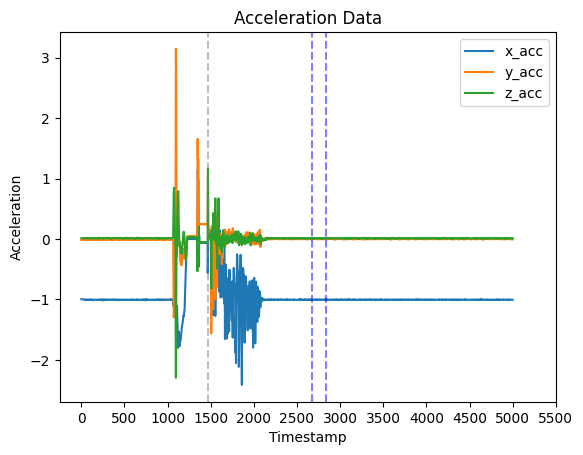

In [22]:
# Assume data is already defined
df = results

# Plot the accelerometer values
columns_to_plot = [col for col in df.columns if '_acc' in col]
df.plot(x='timestamp', y=columns_to_plot, kind='line')

# Vertical gray line for when the dice is picked up
plt.axvline(x=total_raap_duration, color='gray', linestyle='--', alpha=0.5, label='Start to Pickup')

# Vertical red line for when the dice leaves the hand
plt.axvline(x=start_tot_loslaten, color='blue', linestyle='--', alpha=0.5, label='Start to Release')

# Vertical blue line for when the dice hits the ground
plt.axvline(x=start_tot_grond, color='blue', linestyle='--', alpha=0.5, label='Start to Ground')

# Set labels and title
plt.xlabel('Timestamp')
plt.ylabel('Acceleration')
plt.title('Acceleration Data')

# Set x-axis grid with a spacing of 500 units
plt.xticks(range(int(df['timestamp'].min()), int(df['timestamp'].max()) + 500, 500))

# Show the plot
plt.show()

In [23]:
dob.disconnect()

we are disconnected!
